In [1]:
import scipy.io
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

from joblib import Parallel, delayed
import time
from itertools import product
import pandas as pd

from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

In [2]:
def nearest_neighbor(src, dst, y_src, y_dst, class_aware = True):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape
    
    distances = np.zeros(y_src.shape)
    indices = np.zeros(y_src.shape, dtype=int)
    
    if class_aware:
        class1_src = np.where(y_src == 1)[0]
        class0_src = np.where(y_src == 0)[0]
        class1_dst = np.where(y_dst == 1)[0]
        class0_dst = np.where(y_dst == 0)[0]

        neigh_1 = NearestNeighbors(n_neighbors=1)
        neigh_1.fit(dst[class1_dst])
        distances_1, indices_1 = neigh_1.kneighbors(src[class1_src], return_distance=True)
    
        neigh_2 = NearestNeighbors(n_neighbors=1)
        neigh_2.fit(dst[class0_dst])
        distances_2, indices_2 = neigh_2.kneighbors(src[class0_src], return_distance=True)
        
        closest_class1 = class1_src[indices_1]
        closest_class0 = class0_src[indices_2]
        
        count = 0
        for i in class1_src:
            distances[i] = distances_1[count]
            indices[i] = closest_class1[count]
            count = count + 1
        
        count = 0
        for i in class0_src:
            distances[i] = distances_2[count]
            indices[i] = closest_class0[count]
            count = count + 1
    
    else:
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, indices = neigh.kneighbors(src, return_distance=True)
    
    return distances.ravel(), indices.ravel()

In [3]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [4]:
def icp(A, B, y_src, y_dst, init_pose=None, max_iterations=500, tolerance=1e-26):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    
    imbalance = []
    
    class1_src = np.where(y_src == 1)[0]
    class0_src = np.where(y_src == 0)[0]
    class1_dst = np.where(y_dst == 1)[0]
    class0_dst = np.where(y_dst == 0)[0]
    
    imbalance.append(len(class1_src))
    imbalance.append(len(class0_src))
    imbalance.append(len(class1_dst))
    imbalance.append(len(class0_dst))
    
    mi = min(imbalance)
    
    X_1 = src[:,class1_src[0:mi]]
    X_2 = src[:,class0_src[0:mi]]
    
    src_subsample = np.concatenate((X_1, X_2),1)
    y_src_sub = np.concatenate((np.ones(mi), np.zeros(mi)))
    
    X_1 = dst[:,class1_dst[0:mi]]
    X_2 = dst[:,class0_dst[0:mi]]
    dst_subsample = np.concatenate((X_1, X_2),1)
    y_dst_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    for i in range(max_iterations):
        
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src_subsample[:m,:].T, dst_subsample[:m,:].T, y_src_sub, y_dst_sub)
        #distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T, y_src, y_dst)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src_subsample[:m,:].T, dst_subsample[:m,indices].T)
        #T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src_subsample = np.dot(T, src_subsample)
        src = np.dot(T, src)
        #src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
        

    # calculate final transformation
    #T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i

In [5]:
# Supervised point set registration
x1, y1 = generate_gaussian_parity(500)
x2, y2 = generate_gaussian_parity(500, angle_params=np.pi/2)
#x1, y1 = make_XOR(n_samples=500)
#x2, y2 = make_XOR(n_samples=500, theta_rotation=np.pi/2)

#Grid Setup for XOR1
h = 0.05 
X1 = x1.copy()
Y1 = y1.copy()
x1_min, x1_max = X1[:,0].min()-1, X1[:,0].max()+1 
y1_min, y1_max = X1[:,1].min()-1, X1[:,1].max()+1 
xx1, yy1 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(y1_min, y1_max, h))
grid1 = np.c_[xx1.ravel(), yy1.ravel()]

#Grid Setup for XOR2
h = 0.05 
X2 = x2.copy()
Y2 = y2.copy()
x2_min, x2_max = X2[:,0].min()-1, X2[:,0].max()+1 
y2_min, y2_max = X2[:,1].min()-1, X2[:,1].max()+1 
xx2, yy2 = np.meshgrid(np.arange(x2_min, x2_max, h), np.arange(y2_min, y2_max, h))
grid2 = np.c_[xx2.ravel(), yy2.ravel()]

#Grid Setup for XOR3
h = 0.05 
T, X_3, i = icp(x2.copy(), x1.copy(), y2.copy(), y1.copy())
X3 = X_3.T[:,0:2]

Y3 = y2.copy()
x3_min, x3_max = X3[:,0].min()-1, X3[:,0].max()+1 
y3_min, y3_max = X3[:,1].min()-1, X3[:,1].max()+1 
xx3, yy3 = np.meshgrid(np.arange(x3_min, x3_max, h), np.arange(y3_min, y3_max, h))
grid3 = np.c_[xx3.ravel(), yy3.ravel()]

#Predicting for XOR1
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ1 = clf.fit(X1,Y1).predict_proba(grid1)[:,0]
ZZ1 = ZZ1.reshape(xx1.shape)

#Predicting for XOR2
clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ2 = clf.fit(X2,Y2).predict_proba(grid2)[:,0]
ZZ2 = ZZ2.reshape(xx2.shape)

clf = RandomForestClassifier(n_estimators=500, max_depth=20)
ZZ3 = clf.fit(X3,Y3).predict_proba(grid3)[:,0]
ZZ3 = ZZ3.reshape(xx3.shape)

<ipython-input-6-a7cb54445e48>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx1, yy1, ZZ1);
<ipython-input-6-a7cb54445e48>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx2, yy2, ZZ2);
<ipython-input-6-a7cb54445e48>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'ne

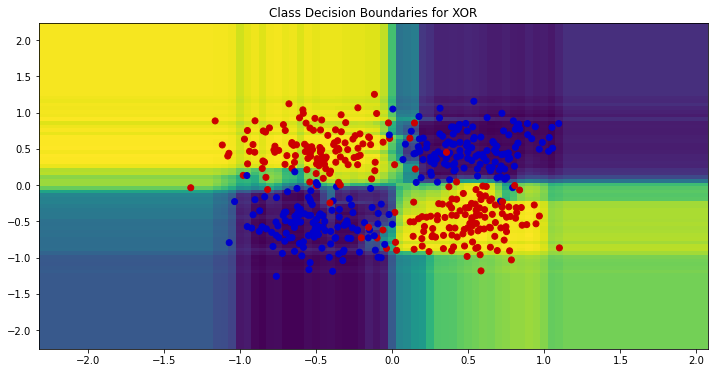

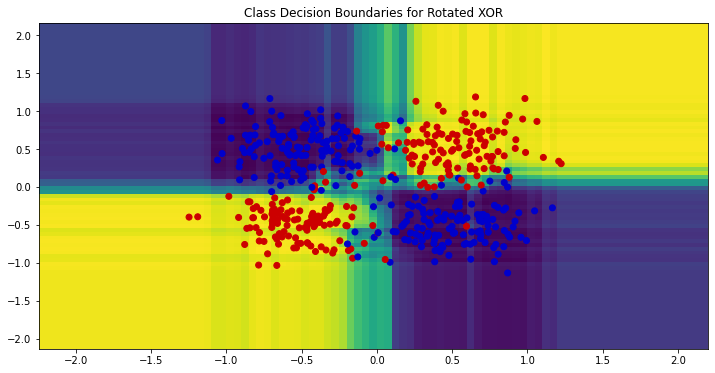

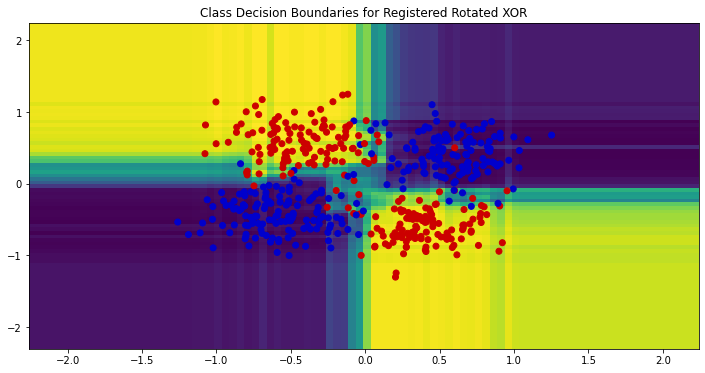

In [6]:
#Plot the decision boundary for XOR1
plt.figure(figsize=(12,6));
plt.pcolormesh(xx1, yy1, ZZ1);
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=cmap_bold);
plt.xlim(xx1.min(), xx1.max());
plt.ylim(yy1.min(), yy1.max());
plt.title('Class Decision Boundaries for XOR');

#Plot the decision boundary for XOR2
plt.figure(figsize=(12,6));
plt.pcolormesh(xx2, yy2, ZZ2);
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx2.min(), xx2.max());
plt.ylim(yy2.min(), yy2.max());
plt.title('Class Decision Boundaries for Rotated XOR');

#Plot the decision boundary for XOR3
plt.figure(figsize=(12,6));
plt.pcolormesh(xx3, yy3, ZZ3);
plt.scatter(X3[:,0], X3[:,1], c=y2, cmap=cmap_bold);
plt.xlim(xx3.min(), xx3.max());
plt.ylim(yy3.min(), yy3.max());
plt.title('Class Decision Boundaries for Registered Rotated XOR');

In [7]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None, register=False):
    
    """
    A function to do progressive experiment between two tasks
    where the task data is generated using Gaussian parity.
    
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    
    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.
        
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
            
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
            
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
        
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        
    
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    #X_task1, y_task1 = make_XOR(n_samples=n_task1, theta_rotation=task1_angle)
    #test_task1, test_label_task1 = make_XOR(n_samples=n_test, theta_rotation=task1_angle)
    
    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)
    #X_task2, y_task2 = make_XOR(n_samples=n_task2, theta_rotation=task2_angle)
    #test_task2, test_label_task2 = make_XOR(n_samples=n_test, theta_rotation=task2_angle)
    
    if register:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:,0:2]
    
        #m = test_task2.shape[1]
        #src = np.ones((m+1,test_task2.shape[0]))
        #src[:m,:] = np.copy(test_task2.T)
        #src = np.dot(T, src)
        #test_task2 = src.T[:,0:2]

    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
    uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1=progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(
        uf_task1 == test_label_task1
    )
    errors[1] = 1 - np.mean(
        l2f_task1 == test_label_task1
    )

    return errors

In [8]:
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 1000

mean_te = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample)),
            register=False
        ) for _ in range(mc_rep)
      )
    )

    mean_te[ii] = np.mean(error[:,0])/np.mean(error[:,1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   51.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   52.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.1s
[Paral

In [9]:
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 1000

mean_te_reg = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample)),
            register=True
        ) for _ in range(mc_rep)
      )
    )

    mean_te_reg[ii] = np.mean(error[:,0])/np.mean(error[:,1])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   54.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   59.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s
[Paral

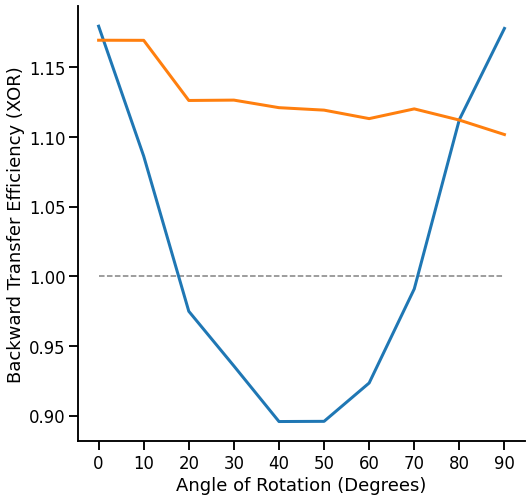

In [10]:
import seaborn as sns

angle_sweep = range(0,91,10)

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(angle_sweep,mean_te,linewidth = 3)
ax.plot(angle_sweep,mean_te_reg,linewidth = 3)
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)